# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [67]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import os

In [7]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 25000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (25000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [9]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [11]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [13]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [14]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(23953, 10)

In [15]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.812

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [17]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [18]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(23953, 10)


1    20071
0     3882
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [19]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
I drink a lot of tea and this was a nice tea for a change. Lightly flavored and quite tasty.
The bread has a good taste but does not rise properly and only makes 1/2 loaf.  I checked the temp of the water as suggested with bad results.  After raising the temp to 100 degrees I got it to rise to 3/4 loaf.  Pretty expensive for the quality and I won't buy again.
Dog broke the hard plastic the first day by slamming it around by the rope so we have to tape it up everytime we refill. Dog does enjoy, carries it around wanting to play fetch but settles on tug a war. It does keep him occupied trying to get the food out. Container needs to be made of different material to prevent 

In [20]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
I drink a lot of tea and this was a nice tea for a change. Lightly flavored and quite tasty.
The bread has a good taste but does not rise properly and only makes 1/2 loaf.  I checked the temp of the water as suggested with bad results.  After raising the temp to 100 degrees I got it to rise to 3/4 loaf.  Pretty expensive for the quality and I won't buy again.
Dog broke the hard plastic the first day by slamming it around by the rope so we have to tape it up everytime we refill. Dog does enjoy, carries it around wanting to play fetch but settles on tug a war. It does keep him occupied trying to get the food out. Container needs to be made of different material to prevent 

In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

The bread has a good taste but does not rise properly and only makes 1/2 loaf.  I checked the temp of the water as suggested with bad results.  After raising the temp to 100 degrees I got it to rise to 3/4 loaf.  Pretty expensive for the quality and I will not buy again.


In [24]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [25]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

The bread has a good taste but does not rise properly and only makes 1 2 loaf I checked the temp of the water as suggested with bad results After raising the temp to 100 degrees I got it to rise to 3 4 loaf Pretty expensive for the quality and I will not buy again 


In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [27]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 23953/23953 [00:08<00:00, 2674.80it/s]


In [28]:
preprocessed_reviews[1500]

'bread good taste not rise properly makes loaf checked temp water suggested bad results raising temp degrees got rise loaf pretty expensive quality not buy'

In [29]:
len(preprocessed_reviews)

23953

In [30]:
final.shape

(23953, 10)

In [31]:
final['Text'] = preprocessed_reviews

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [32]:
## Similartly you can do preprocessing for review summary also.

In [33]:
#soring the values based on time stamp
final.sort_values('Time', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
final = final.drop(['ProductId','Id','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'],axis=1)


In [34]:
final.columns

Index(['Score', 'Text'], dtype='object')

In [35]:
y = final['Score']
text = final['Text']

In [ ]:
y = final['Score']
text = final['Text']

In [36]:
text.shape

(23953,)

In [37]:
# X_train_1, test_df_1, y_train_1, y_test_1 = train_test_split(final, y, stratify=y, test_size=0.7)
# print(X_train_1.shape)
# print(y_train_1.shape)

X_train, test_df, y_train, y_test = train_test_split(text, y, stratify=y, test_size=0.2)
train_df, cv_df, y, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

print(train_df.shape)
print(y.shape)
print(cv_df.shape)
print(y_cv.shape)

(15329,)
(15329,)
(3833,)
(3833,)


In [38]:
y_train.shape

(19162,)

In [39]:
print(np.unique(y_train))
print(np.unique(y_test))
print(np.unique(y_cv))

[0 1]
[0 1]
[0 1]


In [40]:
def do_pickling(filename,data):
    pickling_on= open(filename,"wb")
    pickle.dump(data,pickling_on)

In [243]:
do_pickling('y_trains.pickle',y)
do_pickling('y_tests.pickle',y_test)
do_pickling('y_cvs.pickle',y_cv)


In [41]:
do_pickling('y_train_rbf.pickle',y)
do_pickling('y_test_rbf.pickle',y_test)
do_pickling('y_cv_rbf.pickle',y_cv)


# [4] Featurization

## [4.1] BAG OF WORDS

In [72]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


In [42]:
count_vect = CountVectorizer(ngram_range=(1,3),min_df=10)
bow_feature_train = count_vect.fit_transform(train_df)
bow_feature_test = count_vect.transform(test_df)
bow_feature_cv = count_vect.transform(cv_df)

In [43]:
bow_feature_train.shape

(15329, 9749)

In [95]:
do_pickling('bow_trains.pickle',bow_feature_train)
do_pickling('bow_tests.pickle',bow_feature_test)
do_pickling('bow_cvs.pickle',bow_feature_cv)
do_pickling('count_vects.pickle',count_vect)

In [44]:
count_vect = CountVectorizer(ngram_range=(1,3),min_df=10,max_features=500)
bow_feature_train = count_vect.fit_transform(train_df)
bow_feature_test = count_vect.transform(test_df)
bow_feature_cv = count_vect.transform(cv_df)

In [45]:
do_pickling('bow_train_rbf.pickle',bow_feature_train)
do_pickling('bow_test_rbf.pickle',bow_feature_test)
do_pickling('bow_cv_rbf.pickle',bow_feature_cv)
do_pickling('count_vect_rbf.pickle',count_vect)

## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [111]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


In [112]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3))
tf_idf_train = tf_idf_vect.fit_transform(train_df)
tf_idf_test = tf_idf_vect.transform(test_df)
tf_idf_cv = tf_idf_vect.transform(cv_df)

In [113]:
do_pickling('tfidf_train_li.pickle',tf_idf_train)
do_pickling('tfidf_test_li.pickle',tf_idf_test)
do_pickling('tfidf_cv_li.pickle',tf_idf_cv)
do_pickling('tf_idf_vect_li.pickle',tf_idf_vect)

In [46]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3),min_df=10, max_features=500)
tf_idf_train = tf_idf_vect.fit_transform(train_df)
tf_idf_test = tf_idf_vect.transform(test_df)
tf_idf_cv = tf_idf_vect.transform(cv_df)

In [47]:
do_pickling('tfidf_train_rbf.pickle',tf_idf_train)
do_pickling('tfidf_test_rbf.pickle',tf_idf_test)
do_pickling('tfidf_cv_rbf.pickle',tf_idf_cv)
do_pickling('tf_idf_vect_rbf.pickle',tf_idf_vect)

## [4.4] Word2Vec

In [48]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [49]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8231269121170044), ('good', 0.8118637800216675), ('fantastic', 0.7989206314086914), ('excellent', 0.7700639367103577), ('amazing', 0.7663317918777466), ('wonderful', 0.7623875141143799), ('perfect', 0.7306408286094666), ('decent', 0.694785475730896), ('terrific', 0.6767959594726562), ('delicious', 0.660306453704834)]
[('closest', 0.7931296229362488), ('best', 0.7592700123786926), ('awful', 0.7537202835083008), ('ever', 0.744742751121521), ('horrible', 0.7377067804336548), ('horrendous', 0.7309278845787048), ('personal', 0.7225382328033447), ('greatest', 0.7171108722686768), ('terrible', 0.7056512832641602), ('worse', 0.7049030065536499)]


In [50]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9295
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'available', 'traps', 'unreal', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'received']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [51]:
def getListOfSentences(values):
    list_of_sent=[]
    for sent in values:
        list_of_sent.append(sent.split())
    return list_of_sent

In [52]:
list_of_sent = getListOfSentences(train_df.values)
w2v_model=Word2Vec(list_of_sent,min_count=10,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [53]:

def findAvgWord2Vec(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
    
sent_vectors = findAvgWord2Vec(list_of_sent)
print(len(sent_vectors))
print(len(sent_vectors[0]))
    

100%|██████████| 15329/15329 [00:18<00:00, 817.01it/s]

15329
50


In [129]:
do_pickling('avg_w2v_train_li.pickle',sent_vectors)


In [54]:
do_pickling('avg_w2v_train_rbf.pickle',sent_vectors)


In [55]:
list_of_sent = getListOfSentences(test_df.values)

In [56]:
sent_vectors_test = findAvgWord2Vec(list_of_sent)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 4791/4791 [00:06<00:00, 778.02it/s]

4791
50


In [132]:
do_pickling('avg_w2v_test_li.pickle',sent_vectors_test)


In [57]:
do_pickling('avg_w2v_test_rbf.pickle',sent_vectors_test)


In [58]:
list_of_sent= getListOfSentences(cv_df.values)
sent_vectors_cv = findAvgWord2Vec(list_of_sent)

100%|██████████| 3833/3833 [00:05<00:00, 713.52it/s]


In [134]:
do_pickling('avg_w2v_cv_li.pickle',sent_vectors_cv)


In [59]:
do_pickling('avg_w2v_cv_rbf.pickle',sent_vectors_cv)

#### [4.4.1.2] TFIDF weighted W2v

In [60]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_df)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [61]:
list_of_sentance=[]
for sent in train_df.values:
    list_of_sentance.append(sent.split())


In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 15329/15329 [03:05<00:00, 82.84it/s] 


In [193]:
do_pickling('tfidf_w2v_train_li.pickle',tfidf_sent_vectors)

In [63]:
do_pickling('tfidf_w2v_train_rbf.pickle',tfidf_sent_vectors)

In [64]:
def findTfidfW2V(values):
    tf_idf_matrix = model.transform(values)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    
    list_of_sent=[]
    for sent in values:
        list_of_sent.append(sent.split())

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                if(len(word)!= 1):
                    vec = w2v_model.wv[word]
                    # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                    # to reduce the computation we are 
                    # dictionary[word] = idf value of word in whole courpus
                    # sent.count(word) = tf valeus of word in this review
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [65]:
tfidf_sent_vectors_test = findTfidfW2V(test_df.values)
print(len(tfidf_sent_vectors_test))

100%|██████████| 4791/4791 [00:06<00:00, 758.39it/s]

4791


In [206]:
do_pickling('tfidf_w2v_test_li.pickle',tfidf_sent_vectors_test)

In [66]:
do_pickling('tfidf_w2v_test_rbf.pickle',tfidf_sent_vectors_test)

In [67]:
tfidf_sent_vectors_cv = findTfidfW2V(cv_df.values)

100%|██████████| 3833/3833 [00:06<00:00, 606.70it/s]


In [ ]:
do_pickling('tfidf_w2v_cv_li.pickle',tfidf_sent_vectors_cv)

In [68]:
do_pickling('tfidf_w2v_cv_rbf.pickle',tfidf_sent_vectors_cv)

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

In [13]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD


In [ ]:
# function to load the pickle data
def loadPickleData(filename):
    with open(filename, "rb") as f:    
        final = pickle.load(f)
    return final


In [ ]:
# load the y values because they are common across all feature engineering
y_train = loadPickleData('y_trains.pickle')
y_test = loadPickleData('y_tests.pickle')
y_cv = loadPickleData('y_cvs.pickle')

In [16]:
# encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) # ham will be 0 and spam will be 1
# y_train = np.ravel(encoded_column_vector)

# encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) # ham will be 0 and spam will be 1
# y_test = np.ravel(encoded_column_vector)

# encoded_column = label_binarize(y_cv, classes=['negative','positive']) # ham will be 0 and spam will be 1
# y_cv = np.ravel(encoded_column)

In [17]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [18]:
def drawplots(alpha,auc_array,auc_array_train):
    fig, ax = plt.subplots(2,1,figsize=(10,10))
    a = np.arange(len(alpha))
    l1 = [x for i,x in enumerate(auc_array) if i %2 ==0]
    l2 = [x for i,x in enumerate(auc_array) if i %2 !=0]
    l1_train = [x for i,x in enumerate(auc_array_train) if i %2 ==0]
    l2_train= [x for i,x in enumerate(auc_array) if i %2 !=0]

    ax[0].plot(a, l1,c='g',label="cv")
    for i, txt in enumerate(np.round(l1,3)):
        ax[0].annotate((a[i],str(txt)), (a[i],l1[i]))
    
    ax[0].plot(a, l1_train,c='r',label="train")
    for i, txt in enumerate(np.round(l1_train,3)):
        ax[0].annotate((a[i],str(txt)), (a[i],l1_train[i]),(a[i],l1_train[i]))
        
    ax[0].set_xticks(a)
    ax[0].set_xticklabels(alpha)
    plt.grid()
    ax[0].set_title("Cross Validation Error for each alpha - L1 ")
    ax[0].set_xlabel("Alpha i's")
    ax[0].set_ylabel("Error measure")
    
    ax[1].plot(a, l1,c='g',label="cv")   
    for i, txt in enumerate(np.round(l1,3)):
        ax[1].annotate((a[i],str(txt)), (a[i],l1[i]))
    
    ax[1].plot(a, l1_train,c='r',label="train")
    for i, txt in enumerate(np.round(l1_train,3)):
        ax[1].annotate((a[i],str(txt)), (a[i],l1_train[i]),(a[i],l1_train[i]))
        
    ax[1].set_xticks(a)
    ax[1].set_xticklabels(alpha)
    plt.grid()
    ax[1].set_title("Cross Validation Error for each alpha - L2 ")
    ax[1].set_xlabel("Alpha i's")
    ax[1].set_ylabel("Error measure")

    plt.legend(loc='best')
    plt.show()    

In [57]:
def plotAUC(train_fpr,train_tpr,test_fpr,test_tpr):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(train_fpr, train_tpr,c='g',label="cv")
    ax.plot(test_fpr, test_tpr,c='r',label="train")

    plt.grid()
    ax.set_title("ROC Curve")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")

In [20]:
def getImportantFeatures(indices,feature_names):
    words =[]
    for x in indices:
        words.append(feature_names[x])
    return words

## [5.1] Linear SVM

In [80]:
def calculateMetricC(X,y,alpha,train,y_train):
    auc_array = []
    reg = ['l1','l2']
    for i in alpha:
        for r in reg:
            print("for alpha = {} and regularizer = {}".format(i,r))
            clf = SGDClassifier(class_weight='balanced', alpha=i, penalty=r, loss='hinge', random_state=42)
            clf.fit(train, y_train)
            sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
            sig_clf.fit(train, y_train)
            pred = sig_clf.predict(X)
            area = roc_auc_score(y, pred)
            auc_array.append(area)
            print("Area:",area)
    return auc_array

In [81]:
def performHyperParameterTuningSGD(train,cv,test):
    alpha = [10 ** x for x in range(-4, 4)]
    reg =['l1','l2']
    auc_array = []
    auc_array = calculateMetricC(cv,y_cv,alpha,train,y_train)
    auc_array_train = calculateMetricC(train,y_train,alpha,train,y_train)
    drawplots(alpha,auc_array,auc_array_train)
    best_alpha = np.argmax(auc_array)
    best_a = alpha[int(best_alpha/2)]
    best_r = reg[int(best_alpha%2)]
    print("best alph = {} and regularizer = {}".format(best_a,best_r))
    return (best_a,best_r)
#     clf = SGDClassifier(class_weight='balanced', alpha=best_a, penalty=best_r, loss='hinge', random_state=42)
#     clf.fit(train, y_train)
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
#     sig_clf.fit(train, y_train)
    
#     predict_y = sig_clf.predict(train)
#     plot_confusion_matrix(y_train,predict_y)
#     print('For values of best alpha = ', alpha[int(best_alpha/2)], "The AUC is:",roc_auc_score(y_train, predict_y))
#     predict_y = sig_clf.predict(cv)
#     print('For values of best alpha = ', alpha[int(best_alpha/2)], "The cross validation fpr is:",roc_auc_score(y_cv, predict_y))
#     predict_y = sig_clf.predict(test)
#     plot_confusion_matrix(y_test,predict_y)
#     print('For values of best alpha = ', alpha[int(best_alpha/2)], "The test fpr is:",roc_auc_score(y_test, predict_y))
#     return clf,alpha[best_alpha]

In [82]:
def bestModel(train,cv,test,best_alpha,best_reg):
    clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty=best_reg, loss='hinge', random_state=42)
    clf.fit(train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train, y_train)
    
    predict_y = sig_clf.predict(train)
    plot_confusion_matrix(y_train,predict_y)
    train_fpr,train_tpr , train_thresholds = roc_curve(y_train, predict_y)
    print('For values of best alpha = ',best_alpha, "The AUC is:",roc_auc_score(y_train, predict_y))
    predict_y = sig_clf.predict(cv)
    print('For values of best alpha = ',best_alpha, "The AUC is:",roc_auc_score(y_cv, predict_y))
    predict_y = sig_clf.predict(test)
    plot_confusion_matrix(y_test,predict_y)
    test_fpr,test_tpr ,train_thresholds = roc_curve(y_test, predict_y)
    print('For values of best alpha = ',best_alpha, "The AUC is:",roc_auc_score(y_test, predict_y))
    plotAUC(train_fpr,train_tpr,test_fpr,test_tpr)
    return clf

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [96]:
count_vect = loadPickleData('count_vects.pickle')
train = loadPickleData("bow_trains.pickle")
test = loadPickleData('bow_tests.pickle')
cv = loadPickleData('bow_cvs.pickle')

In [97]:
train.shape

(56174, 36451)

In [98]:
np.unique(y_train)

array([0, 1])

In [108]:
y_train.shape

(56174,)

for alpha = 0.0001 and regularizer = l1
Area: 0.7484121721831872
for alpha = 0.0001 and regularizer = l2
Area: 0.7916132793237385
for alpha = 0.001 and regularizer = l1
Area: 0.6244161733097907
for alpha = 0.001 and regularizer = l2
Area: 0.818126843947641
for alpha = 0.01 and regularizer = l1
Area: 0.500982465596019
for alpha = 0.01 and regularizer = l2
Area: 0.785371241107178
for alpha = 0.1 and regularizer = l1
Area: 0.5000585571802725
for alpha = 0.1 and regularizer = l2
Area: 0.6756612292142128
for alpha = 1 and regularizer = l1
Area: 0.5
for alpha = 1 and regularizer = l2
Area: 0.5562686780842875
for alpha = 10 and regularizer = l1
Area: 0.5
for alpha = 10 and regularizer = l2
Area: 0.5166733196157197
for alpha = 100 and regularizer = l1
Area: 0.5
for alpha = 100 and regularizer = l2
Area: 0.5166733196157197
for alpha = 1000 and regularizer = l1
Area: 0.5
for alpha = 1000 and regularizer = l2
Area: 0.5166733196157197
for alpha = 0.0001 and regularizer = l1
Area: 0.765782955472513

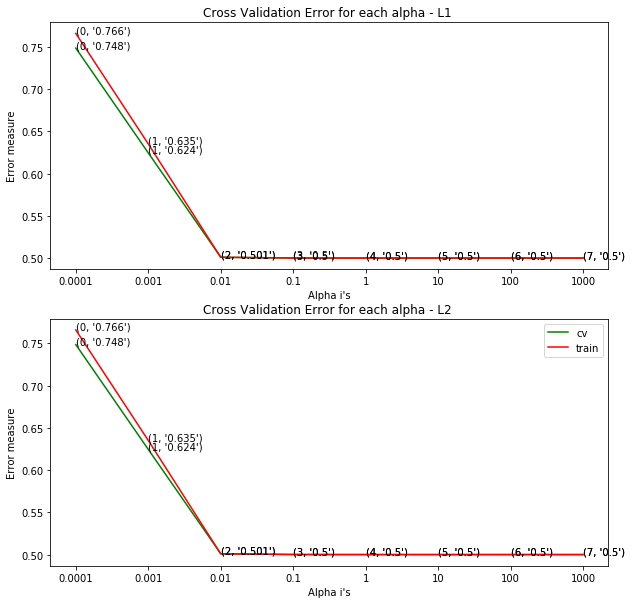

best alph = 0.001 and regularizer = l2


In [114]:
best_alpha,best_reg = performHyperParameterTuningSGD(train,cv,test)

-------------------- Confusion matrix --------------------


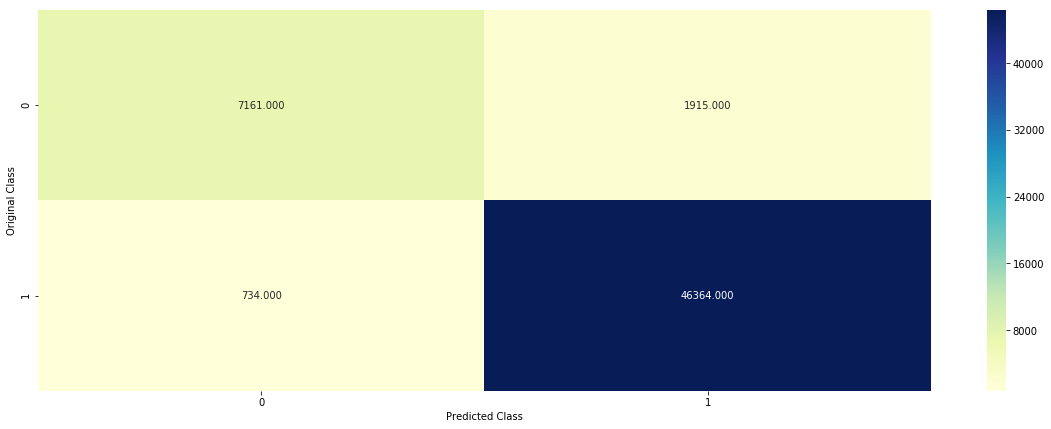

For values of best alpha =  0.001 The AUC is: 0.8867097203114326
For values of best alpha =  0.001 The AUC is: 0.818126843947641
-------------------- Confusion matrix --------------------


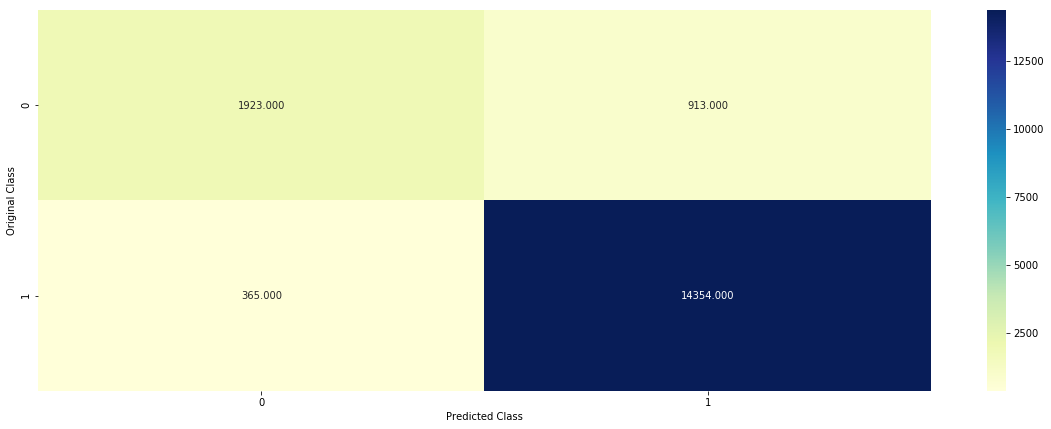

For values of best alpha =  0.001 The AUC is: 0.8266349103482626


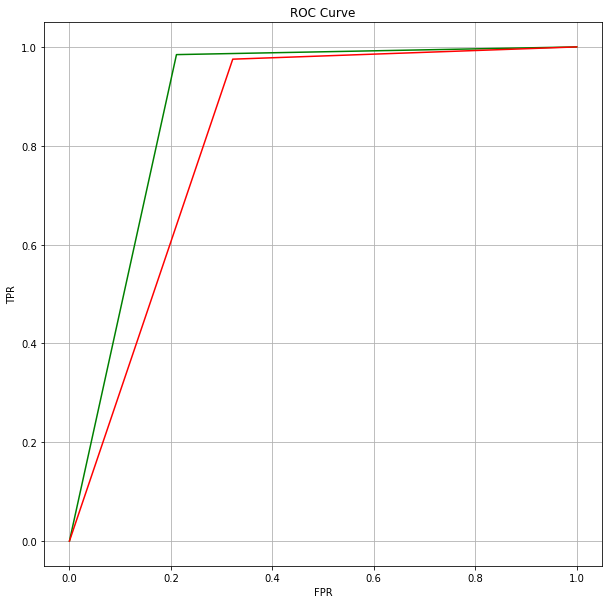

In [110]:
clf = bestModel(train,cv,test,best_alpha,best_reg)

In [115]:
count_vect = loadPickleData('count_vects.pickle')
feature_names = count_vect.get_feature_names()

In [116]:
indices = np.argsort(-clf.coef_)[0][:]
negative_indices = indices[-10:]
words = getImportantFeatures(negative_indices,feature_names)
print(words)

['not great', 'disappointment', 'not good', 'not recommend', 'disappointing', 'awful', 'terrible', 'disappointed', 'not worth', 'worst']


In [117]:
positive_indices = indices[:10]
words = getImportantFeatures(positive_indices,feature_names)
print(words)

['not disappointed', 'delicious', 'perfect', 'amazing', 'wonderful', 'best', 'yummy', 'loves', 'excellent', 'great']


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [115]:
train = loadPickleData("tfidf_train_li.pickle")
test = loadPickleData('tfidf_test_li.pickle')
cv = loadPickleData('tfidf_cv_li.pickle')

for alpha = 0.0001 and regularizer = l1
Area: 0.8224443365250647
for alpha = 0.0001 and regularizer = l2
Area: 0.8573682767551948
for alpha = 0.001 and regularizer = l1
Area: 0.6420815215509699
for alpha = 0.001 and regularizer = l2
Area: 0.8011368963571596
for alpha = 0.01 and regularizer = l1
Area: 0.5
for alpha = 0.01 and regularizer = l2
Area: 0.799863011006841
for alpha = 0.1 and regularizer = l1
Area: 0.5
for alpha = 0.1 and regularizer = l2
Area: 0.799863011006841
for alpha = 1 and regularizer = l1
Area: 0.5
for alpha = 1 and regularizer = l2
Area: 0.799863011006841
for alpha = 10 and regularizer = l1
Area: 0.5
for alpha = 10 and regularizer = l2
Area: 0.799863011006841
for alpha = 100 and regularizer = l1
Area: 0.5
for alpha = 100 and regularizer = l2
Area: 0.799863011006841
for alpha = 1000 and regularizer = l1
Area: 0.5
for alpha = 1000 and regularizer = l2
Area: 0.799863011006841
for alpha = 0.0001 and regularizer = l1
Area: 0.7901993234253023
for alpha = 0.0001 and regulari

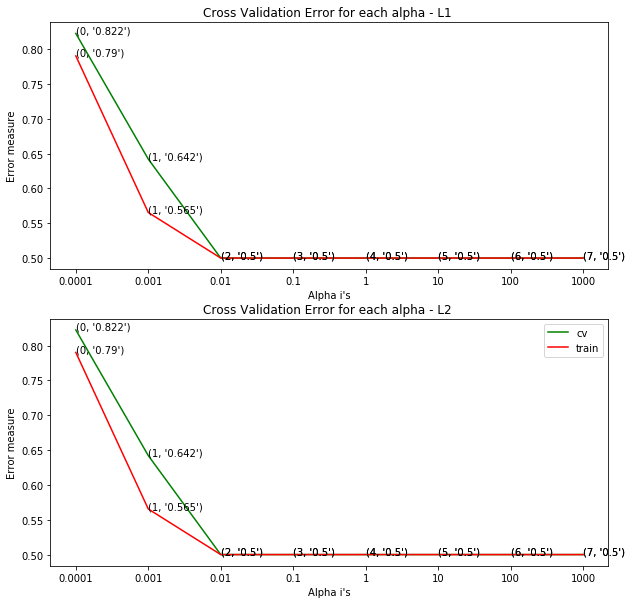

best alph = 0.0001 and regularizer = l2


In [116]:
best_alpha,best_reg = performHyperParameterTuningSGD(train,cv,test)

-------------------- Confusion matrix --------------------


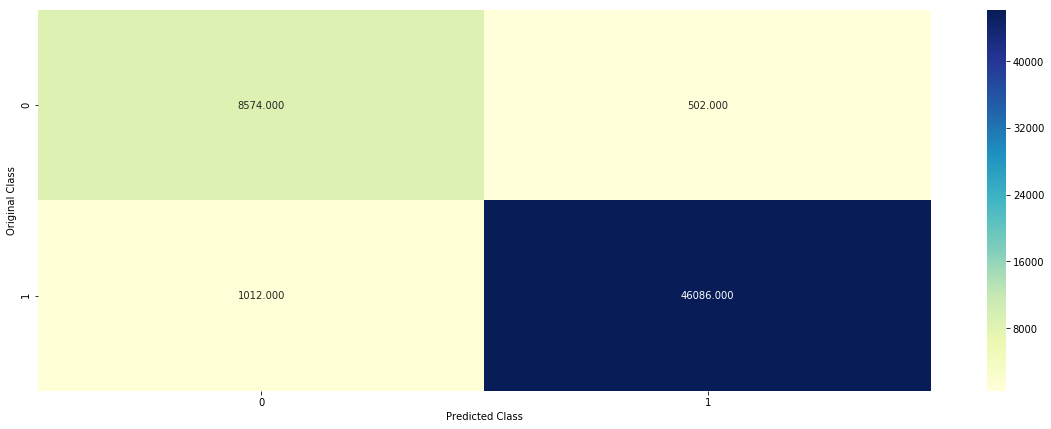

For values of best alpha =  0.0001 The AUC is: 0.9616010892285192
For values of best alpha =  0.0001 The AUC is: 0.8573682767551948
-------------------- Confusion matrix --------------------


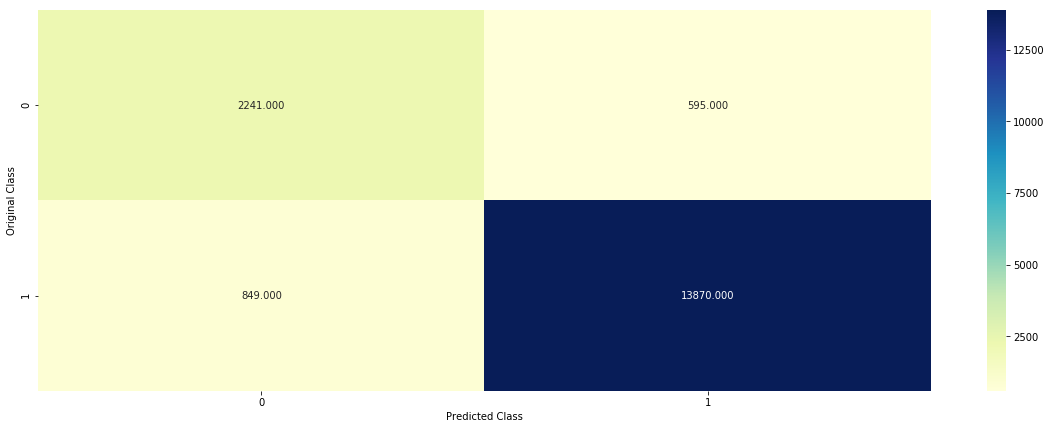

For values of best alpha =  0.0001 The AUC is: 0.86625845613132


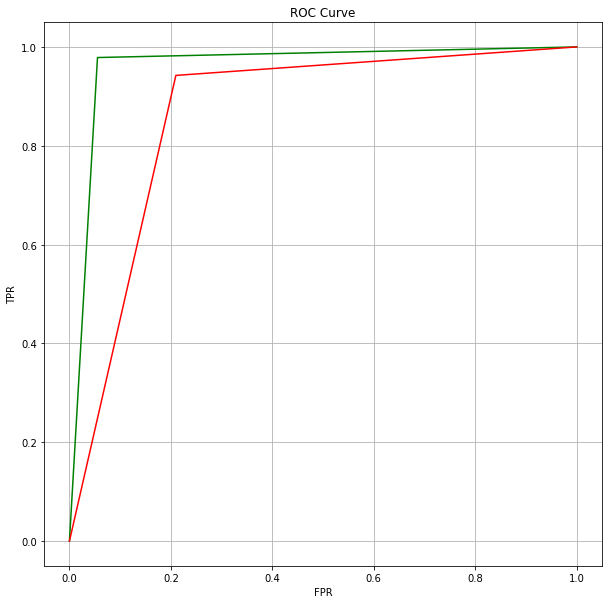

In [117]:
clf = bestModel(train,cv,test,best_alpha,best_reg)

In [121]:
tf_idf_vect = loadPickleData('tf_idf_vect_li.pickle')
feature_names = tf_idf_vect.get_feature_names()

In [122]:
indices = np.argsort(-clf.coef_)[0][:]
negative_indices = indices[-10:]
words = getImportantFeatures(negative_indices,feature_names)
print(words)

['awful', 'unfortunately', 'terrible', 'horrible', 'thought', 'not good', 'worst', 'bad', 'disappointed', 'not']


In [123]:
positive_indices = indices[:10]
words = getImportantFeatures(positive_indices,feature_names)
print(words)

['great', 'best', 'delicious', 'good', 'love', 'perfect', 'loves', 'nice', 'wonderful', 'excellent']


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [215]:
train = loadPickleData("avg_w2v_train_li.pickle")
test = loadPickleData('avg_w2v_test_li.pickle')
cv = loadPickleData('avg_w2v_cv_li.pickle')

for alpha = 0.0001 and regularizer = l1
Area: 0.6963407844491293
for alpha = 0.0001 and regularizer = l2
Area: 0.6961973015788355
for alpha = 0.001 and regularizer = l1
Area: 0.7089738083407957
for alpha = 0.001 and regularizer = l2
Area: 0.7095499668288265
for alpha = 0.01 and regularizer = l1
Area: 0.6997691398607091
for alpha = 0.01 and regularizer = l2
Area: 0.7081348256150704
for alpha = 0.1 and regularizer = l1
Area: 0.5145121685338903
for alpha = 0.1 and regularizer = l2
Area: 0.6989565256447325
for alpha = 1 and regularizer = l1
Area: 0.5
for alpha = 1 and regularizer = l2
Area: 0.6740762366204142
for alpha = 10 and regularizer = l1
Area: 0.5
for alpha = 10 and regularizer = l2
Area: 0.5275648615746811
for alpha = 100 and regularizer = l1
Area: 0.5
for alpha = 100 and regularizer = l2
Area: 0.6726266797292784
for alpha = 1000 and regularizer = l1
Area: 0.5
for alpha = 1000 and regularizer = l2
Area: 0.6726266797292784
for alpha = 0.0001 and regularizer = l1
Area: 0.705315144583

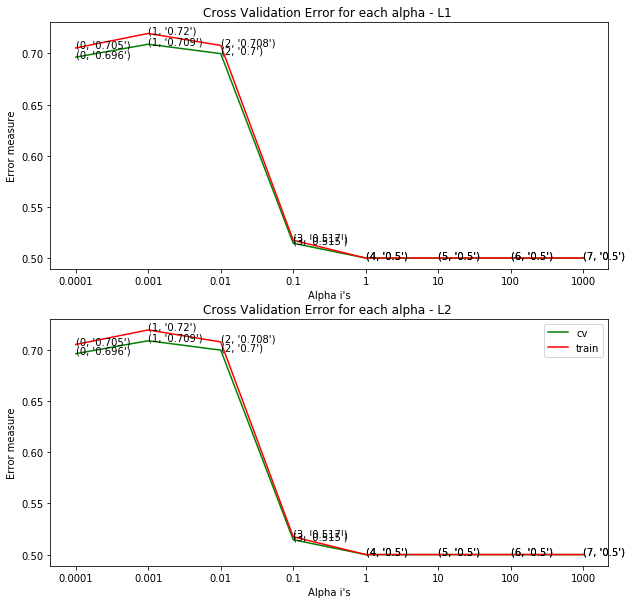

best alph = 0.001 and regularizer = l2


In [216]:
best_alpha,best_reg = performHyperParameterTuningSGD(train,cv,test)

-------------------- Confusion matrix --------------------


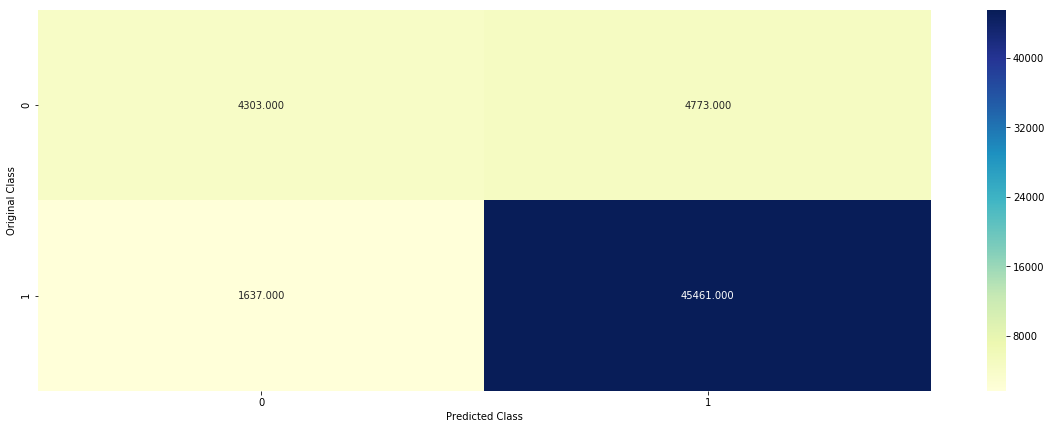

For values of best alpha =  0.001 The AUC is: 0.7196751109119903
For values of best alpha =  0.001 The AUC is: 0.7095499668288265
-------------------- Confusion matrix --------------------


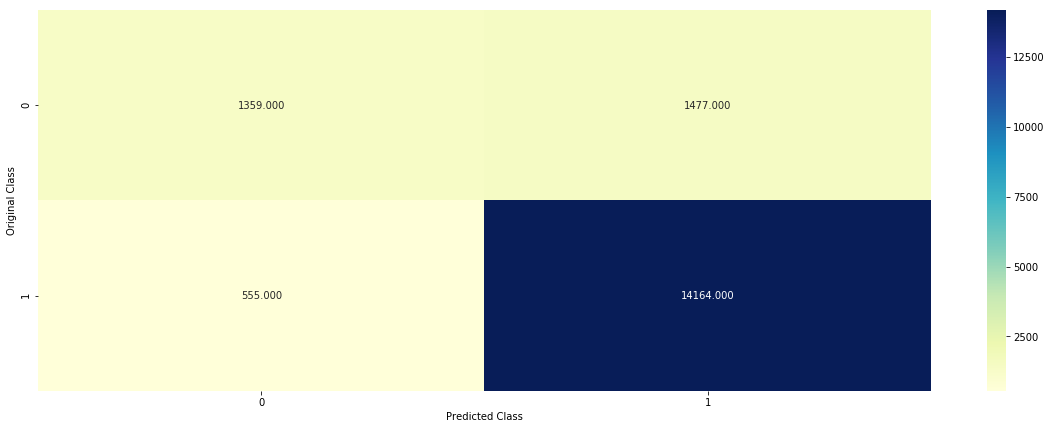

For values of best alpha =  0.001 The AUC is: 0.7207448424270713


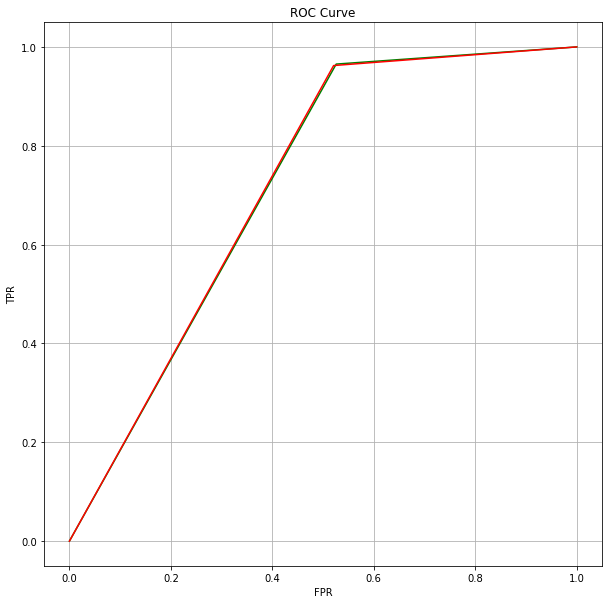

In [137]:
clf = bestModel(train,cv,test,best_alpha,best_reg)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [14]:
train = loadPickleData("tfidf_w2v_train_li.pickle")
test = loadPickleData('tfidf_w2v_test_li.pickle')
cv = loadPickleData('tfidf_w2v_cv_li.pickle')

for alpha = 0.0001 and regularizer = l1
Area: 0.6561567663111878
for alpha = 0.0001 and regularizer = l2
Area: 0.647633730358127
for alpha = 0.001 and regularizer = l1
Area: 0.6798078598370543
for alpha = 0.001 and regularizer = l2
Area: 0.6795633569414774
for alpha = 0.01 and regularizer = l1
Area: 0.6756773235494746
for alpha = 0.01 and regularizer = l2
Area: 0.6842128606838782
for alpha = 0.1 and regularizer = l1
Area: 0.5392145590105353
for alpha = 0.1 and regularizer = l2
Area: 0.6773391946656635
for alpha = 1 and regularizer = l1
Area: 0.5
for alpha = 1 and regularizer = l2
Area: 0.6485934205983163
for alpha = 10 and regularizer = l1
Area: 0.5
for alpha = 10 and regularizer = l2
Area: 0.6440427098743425
for alpha = 100 and regularizer = l1
Area: 0.5
for alpha = 100 and regularizer = l2
Area: 0.6440427098743425
for alpha = 1000 and regularizer = l1
Area: 0.5
for alpha = 1000 and regularizer = l2
Area: 0.6440427098743425
for alpha = 0.0001 and regularizer = l1
Area: 0.6590004626569

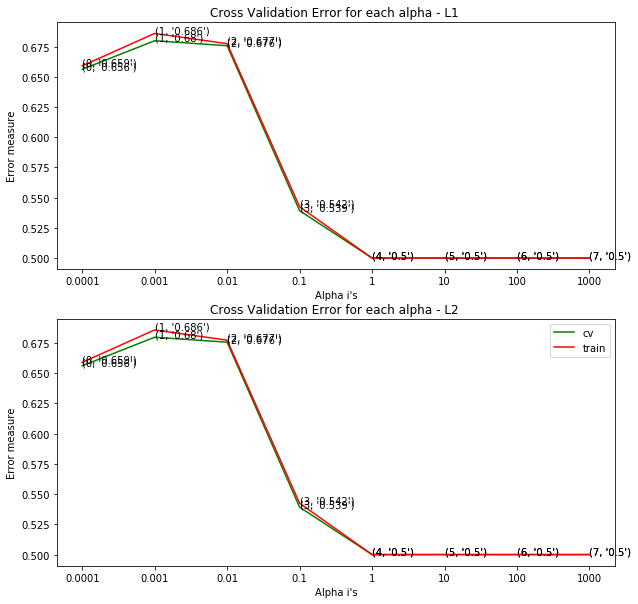

best alph = 0.01 and regularizer = l2


In [15]:
best_alpha,best_reg = performHyperParameterTuningSGD(train,cv,test)

-------------------- Confusion matrix --------------------


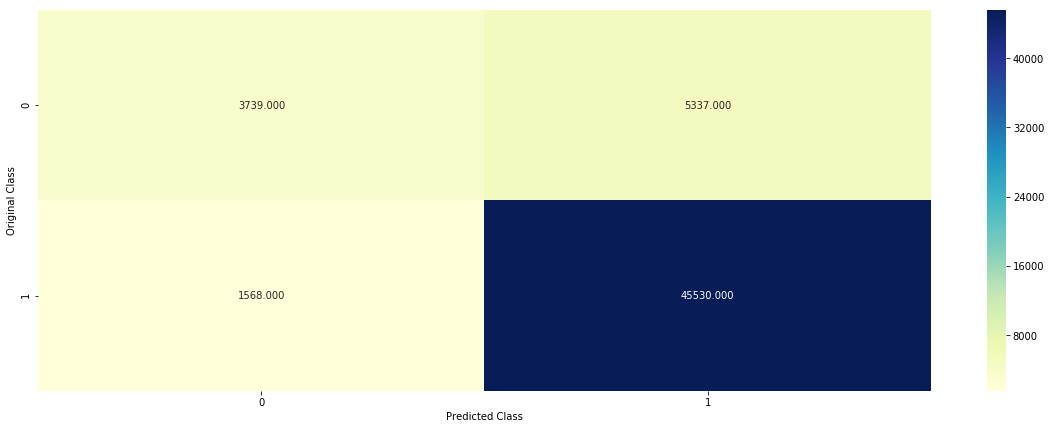

For values of best alpha =  0.01 The AUC is: 0.6893366697246579
For values of best alpha =  0.01 The AUC is: 0.6842128606838782
-------------------- Confusion matrix --------------------


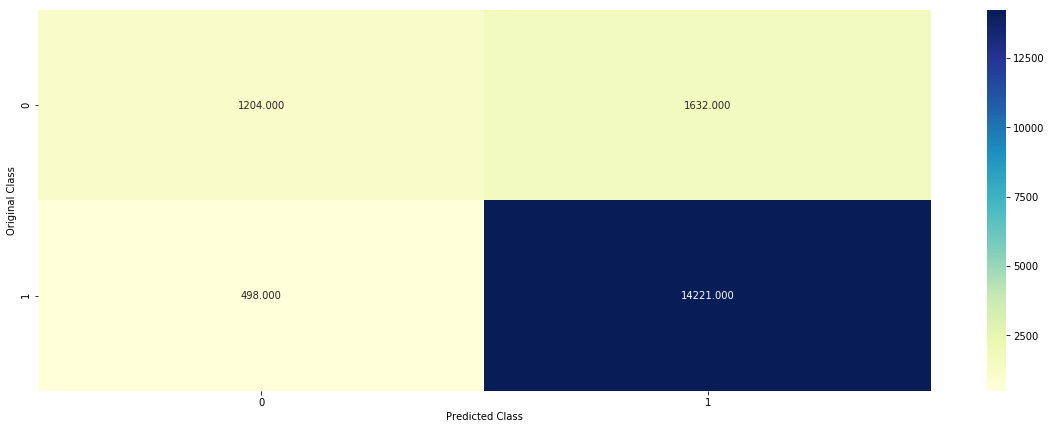

For values of best alpha =  0.01 The AUC is: 0.6953538938330479


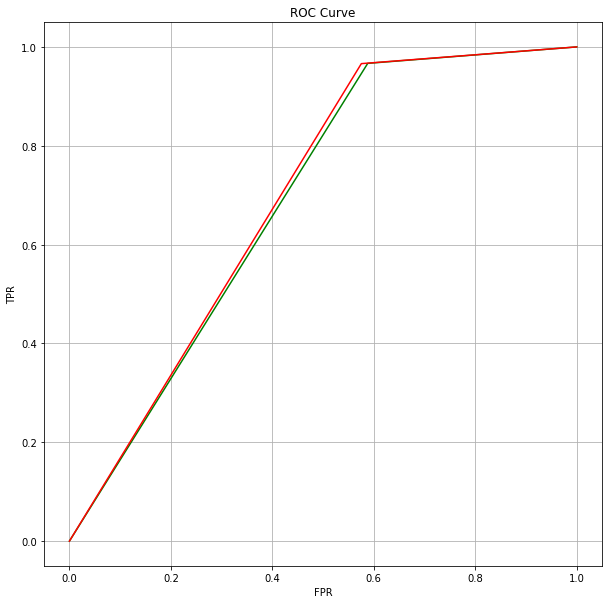

In [16]:
clf = bestModel(train,cv,test,best_alpha,best_reg)

## [5.2] RBF SVM

In [ ]:
gamma = [10**x for x in range(-3,2)]
alpha = [10**x for x in range(-4,4)]

In [ ]:
def calculateMetric(X,y,train,y_train):
    auc_array = []
    C = np.zeros((len(gamma),len(alpha)))
    for row,i in enumerate(gamma):
        for col,g in enumerate(alpha):
            print("for alpha = {} and gamma = {} ".format(i,g))
            clf = SVC(C=g,kernel='rbf',gamma = i,probability=True, class_weight='balanced')
            clf.fit(train, y_train)
            pred = clf.predict(X)
            area = roc_auc_score(y, pred)
            auc_array.append(area)
            print("Area:",area)
            C[row][col] = area
    return (auc_array,C)

In [ ]:
def drawHeatMap(C,title):
    parameters = {'alpha' : alpha,
    'gamma' : gamma}
    labels_y = parameters['gamma']
    labels_x = parameters['alpha']
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".6f", xticklabels=labels_x, yticklabels=labels_y)
    plt.xlabel('C values')
    plt.ylabel('Gamma values')
    plt.title(title)
    plt.show()

In [ ]:
def drawplots(auc_array,auc_array_train):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    a = np.arange(len(alpha))

    ax.plot(a, auc_array,c='g',label="cv")
    for i, txt in enumerate(np.round(auc_array,3)):
        ax.annotate((a[i],str(txt)), (a[i],auc_array[i]))
    
    ax.plot(a, auc_array_train,c='r',label="train")
    for i, txt in enumerate(np.round(auc_array_train,3)):
        ax.annotate((a[i],str(txt)), (a[i],auc_array_train[i]),(a[i],auc_array_train[i]))
        
    ax.set_xticks(a)
    ax.set_xticklabels(alpha)
    plt.grid()
    ax.set_title("Cross Validation AUC for each alpha ")
    ax.set_xlabel("Alpha i's")
    ax.set_ylabel("AUC measure")
    
    plt.legend(loc='best')
    plt.show()    

In [ ]:
def performHyperParameterTuningRBF(train,cv,test):
    auc_array = []
    auc_array,C_cv = calculateMetric(cv,y_cv,train,y_train)
    auc_array_train,C_train = calculateMetric(train,y_train,train,y_train)
    drawHeatMap(C_cv,'Cv Scores')
    drawHeatMap(C_train,'Train scores')
    best_ar = np.argmax(auc_array)
    print(best_ar)
    best_alpha = alpha[int(best_ar%8)]
    best_gamma = gamma[int(best_ar/8)]
    print("best alph = {} and gamma ={} ".format(best_alpha,best_gamma))
    clf = SVC(C=best_alpha,gamma = best_gamma,kernel='rbf',probability=True, class_weight='balanced')
    clf.fit(train, y_train)
    
    predict_y = clf.predict(train)
    plot_confusion_matrix(y_train,predict_y)
    train_fpr,train_tpr , train_thresholds = roc_curve(y_train, predict_y)

    print('For values of best alpha = ', best_alpha, "The AUC is:",roc_auc_score(y_train, predict_y))
    predict_y = clf.predict(cv)
    print('For values of best alpha = ', best_alpha, "The cross validation AUC is:",roc_auc_score(y_cv, predict_y))
    predict_y = clf.predict(test)
    plot_confusion_matrix(y_test,predict_y)
    print('For values of best alpha = ', best_alpha, "The test AUC is:",roc_auc_score(y_test, predict_y))
    test_fpr,test_tpr ,train_thresholds = roc_curve(y_test, predict_y)
    plotAUC(train_fpr,train_tpr,test_fpr,test_tpr)
    return clf,best_alpha

In [ ]:
# load the y values because they are common across all feature engineering
y_train = loadPickleData('y_train_rbf.pickle')
y_test = loadPickleData('y_test_rbf.pickle')
y_cv = loadPickleData('y_cv_rbf.pickle')

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [107]:
train = loadPickleData("bow_train_rbf.pickle")
test = loadPickleData('bow_test_rbf.pickle')
cv = loadPickleData('bow_cv_rbf.pickle')

for alpha = 0.001 and gamma = 0.0001 
Area: 0.5
for alpha = 0.001 and gamma = 0.001 
Area: 0.5
for alpha = 0.001 and gamma = 0.01 
Area: 0.5018464373735368
for alpha = 0.001 and gamma = 0.1 
Area: 0.6684684847281631
for alpha = 0.001 and gamma = 1 
Area: 0.7964552212616535
for alpha = 0.001 and gamma = 10 
Area: 0.8134870142761745
for alpha = 0.001 and gamma = 100 
Area: 0.8126660690686898
for alpha = 0.001 and gamma = 1000 
Area: 0.7864614980457743
for alpha = 0.01 and gamma = 0.0001 
Area: 0.5
for alpha = 0.01 and gamma = 0.001 
Area: 0.5
for alpha = 0.01 and gamma = 0.01 
Area: 0.6438085440467811
for alpha = 0.01 and gamma = 0.1 
Area: 0.7768575671345177
for alpha = 0.01 and gamma = 1 
Area: 0.8079960815219898
for alpha = 0.01 and gamma = 10 
Area: 0.7884583375947283
for alpha = 0.01 and gamma = 100 
Area: 0.7432735133747642
for alpha = 0.01 and gamma = 1000 
Area: 0.7273797634875658
for alpha = 0.1 and gamma = 0.0001 
Area: 0.5
for alpha = 0.1 and gamma = 0.001 
Area: 0.5
for alpha

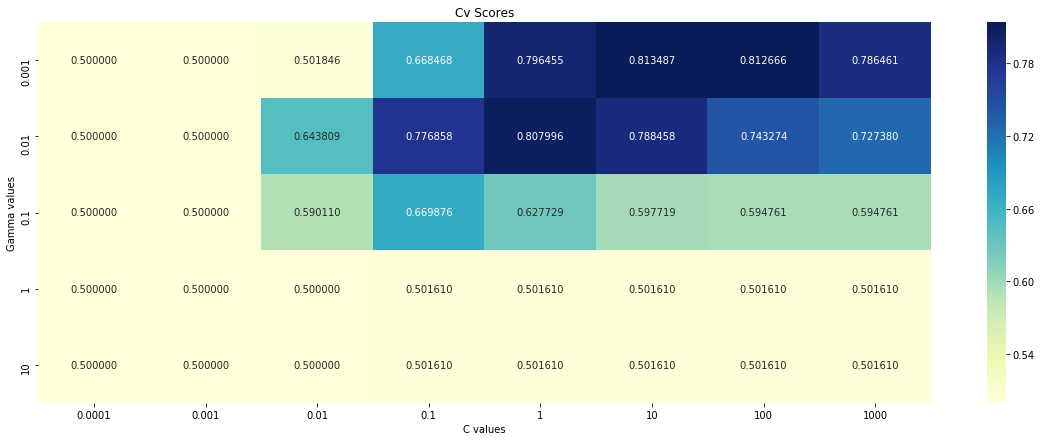

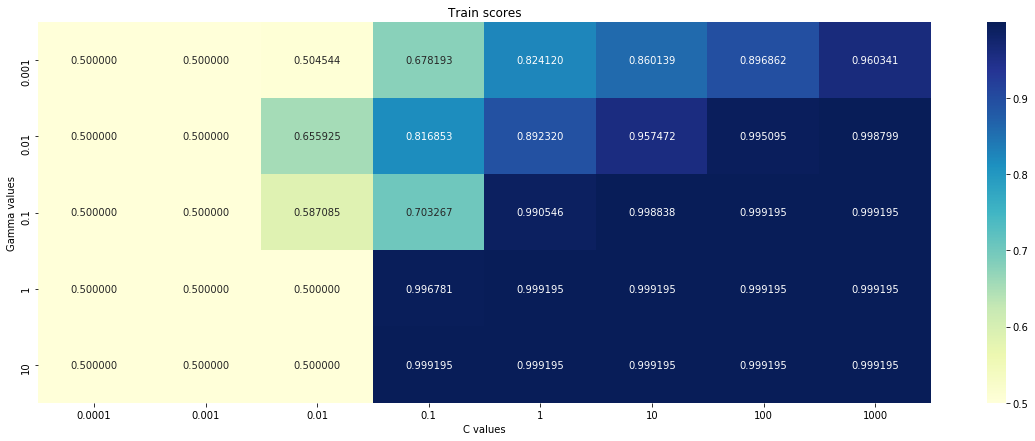

5
best alph = 10 and gamma =0.001 
-------------------- Confusion matrix --------------------


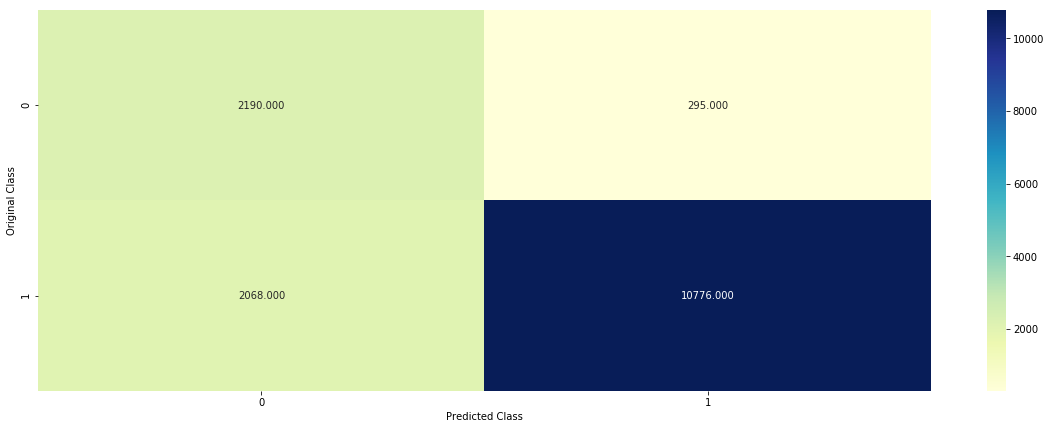

For values of best alpha =  10 The AUC is: 0.8601393474518867
For values of best alpha =  10 The cross validation AUC is: 0.8134870142761745
-------------------- Confusion matrix --------------------


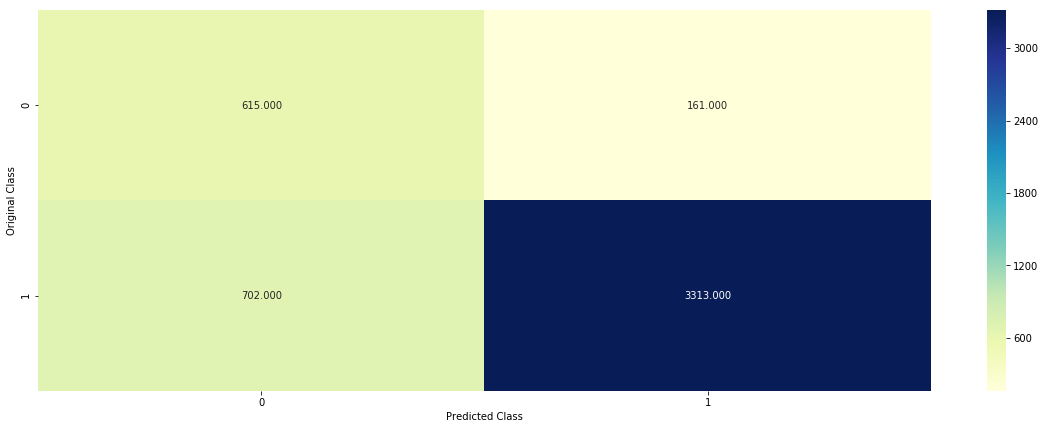

For values of best alpha =  10 The test AUC is: 0.8088407197237164


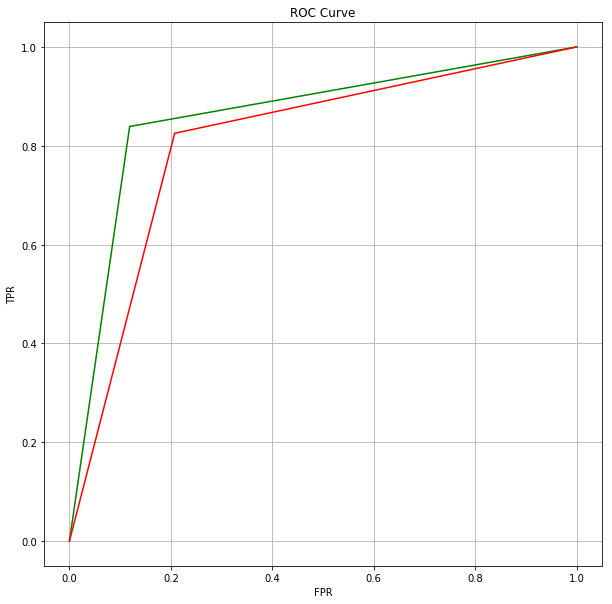

In [108]:
clf,alph = performHyperParameterTuningRBF(train,cv,test)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [111]:
train = loadPickleData("tfidf_train_rbf.pickle")
test = loadPickleData('tfidf_test_rbf.pickle')
cv = loadPickleData('tfidf_cv_rbf.pickle')

for alpha = 0.001 and gamma = 0.0001 
Area: 0.5
for alpha = 0.001 and gamma = 0.001 
Area: 0.5
for alpha = 0.001 and gamma = 0.01 
Area: 0.5
for alpha = 0.001 and gamma = 0.1 
Area: 0.5
for alpha = 0.001 and gamma = 1 
Area: 0.49984433374844334
for alpha = 0.001 and gamma = 10 
Area: 0.8037873273132357
for alpha = 0.001 and gamma = 100 
Area: 0.8238519801950415
for alpha = 0.001 and gamma = 1000 
Area: 0.823798336752476
for alpha = 0.01 and gamma = 0.0001 
Area: 0.5
for alpha = 0.01 and gamma = 0.001 
Area: 0.5
for alpha = 0.01 and gamma = 0.01 
Area: 0.5
for alpha = 0.01 and gamma = 0.1 
Area: 0.5
for alpha = 0.01 and gamma = 1 
Area: 0.8052151452985282
for alpha = 0.01 and gamma = 10 
Area: 0.8230468272159757
for alpha = 0.01 and gamma = 100 
Area: 0.8226282078277314
for alpha = 0.01 and gamma = 1000 
Area: 0.8162032775642067
for alpha = 0.1 and gamma = 0.0001 
Area: 0.5
for alpha = 0.1 and gamma = 0.001 
Area: 0.5
for alpha = 0.1 and gamma = 0.01 
Area: 0.5
for alpha = 0.1 and gamma

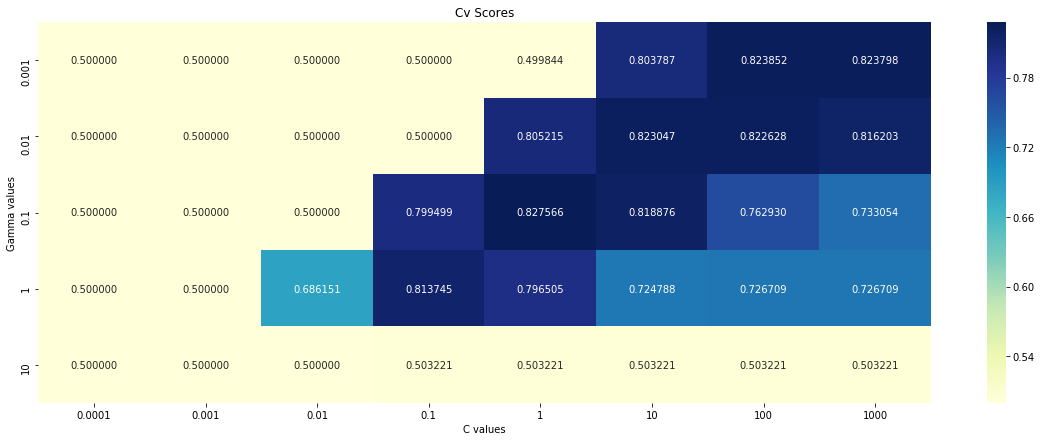

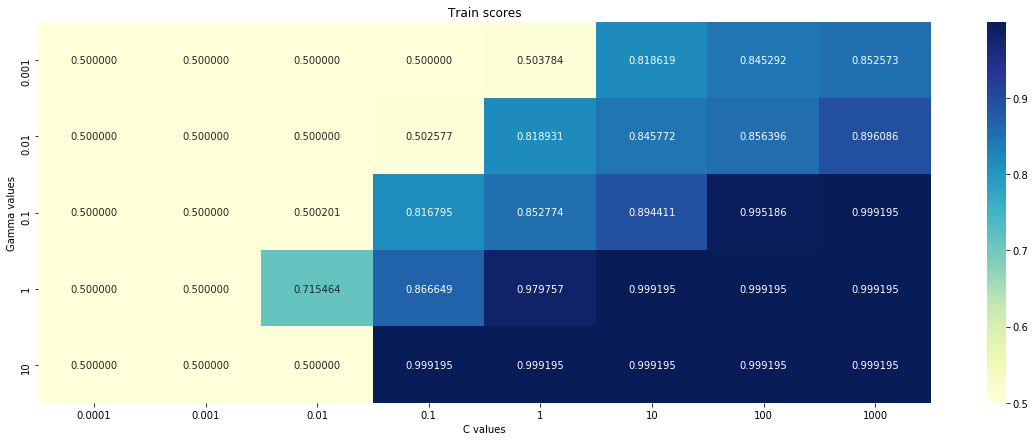

20
best alph = 1 and gamma =0.1 
-------------------- Confusion matrix --------------------


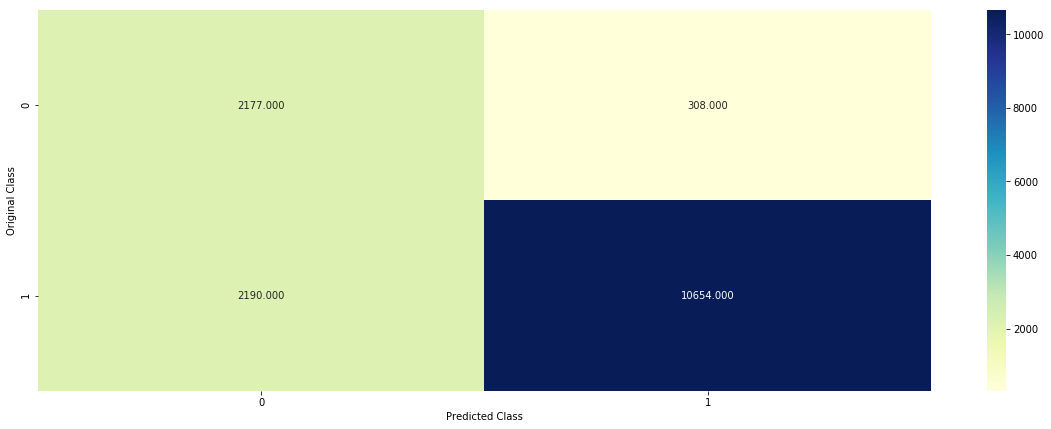

For values of best alpha =  1 The AUC is: 0.8527743540031845
For values of best alpha =  1 The cross validation AUC is: 0.8275664125872583
-------------------- Confusion matrix --------------------


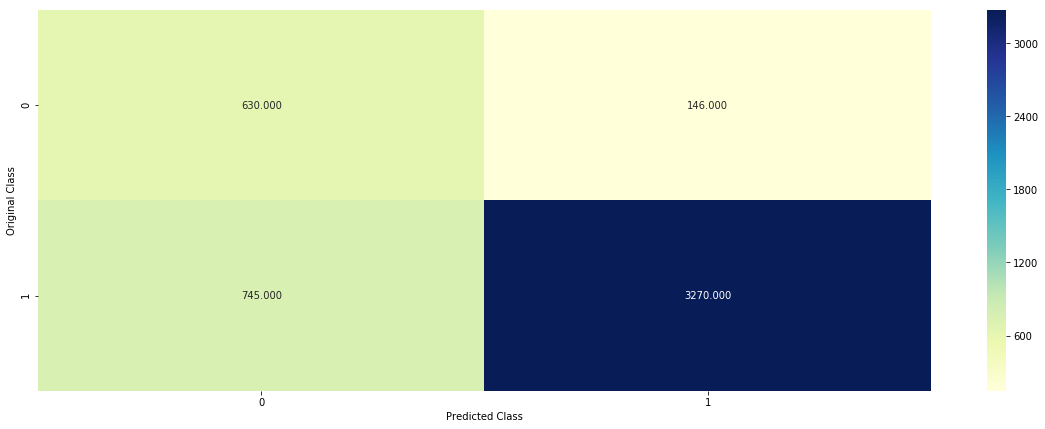

For values of best alpha =  1 The test AUC is: 0.8131507491237756


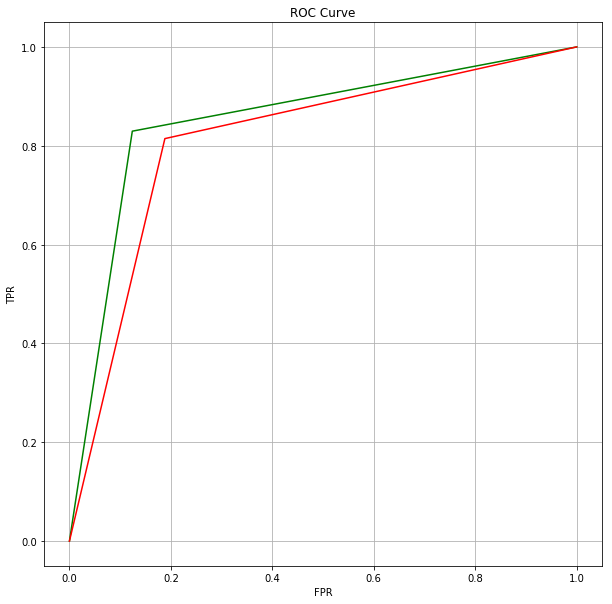

In [112]:
clf,alph = performHyperParameterTuningRBF(train,cv,test)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [113]:
train = loadPickleData("avg_w2v_train_rbf.pickle")
test = loadPickleData('avg_w2v_test_rbf.pickle')
cv = loadPickleData('avg_w2v_cv_rbf.pickle')

for alpha = 0.001 and gamma = 0.0001 
Area: 0.5
for alpha = 0.001 and gamma = 0.001 
Area: 0.5
for alpha = 0.001 and gamma = 0.01 
Area: 0.5
for alpha = 0.001 and gamma = 0.1 
Area: 0.6756624714486537
for alpha = 0.001 and gamma = 1 
Area: 0.7761208471452663
for alpha = 0.001 and gamma = 10 
Area: 0.7963416676192137
for alpha = 0.001 and gamma = 100 
Area: 0.801473389844444
for alpha = 0.001 and gamma = 1000 
Area: 0.7995733090283417
for alpha = 0.01 and gamma = 0.0001 
Area: 0.5
for alpha = 0.01 and gamma = 0.001 
Area: 0.5
for alpha = 0.01 and gamma = 0.01 
Area: 0.6696235734353662
for alpha = 0.01 and gamma = 0.1 
Area: 0.771993059440945
for alpha = 0.01 and gamma = 1 
Area: 0.7947850051036472
for alpha = 0.01 and gamma = 10 
Area: 0.8001475946681426
for alpha = 0.01 and gamma = 100 
Area: 0.7957463256748546
for alpha = 0.01 and gamma = 1000 
Area: 0.8051667659321025
for alpha = 0.1 and gamma = 0.0001 
Area: 0.5
for alpha = 0.1 and gamma = 0.001 
Area: 0.5064412238325282
for alpha =

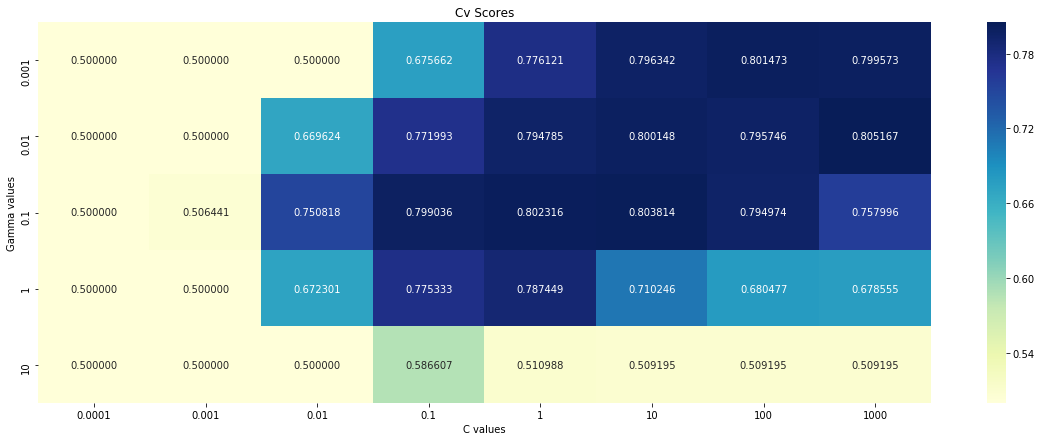

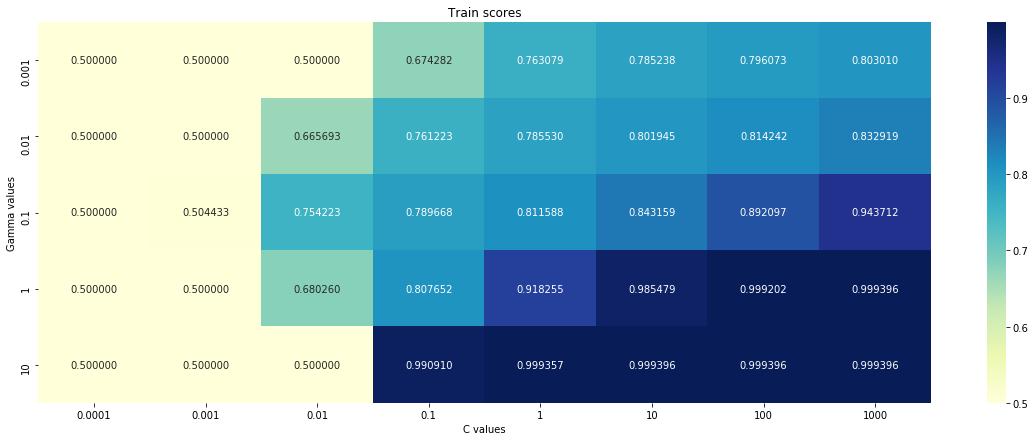

15
best alph = 1000 and gamma =0.01 
-------------------- Confusion matrix --------------------


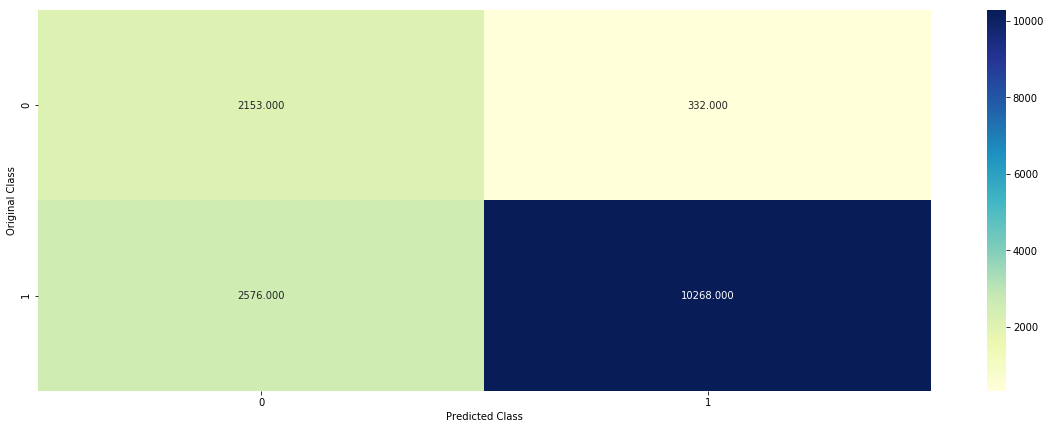

For values of best alpha =  1000 The AUC is: 0.8329189086559219
For values of best alpha =  1000 The cross validation AUC is: 0.8051667659321025
-------------------- Confusion matrix --------------------


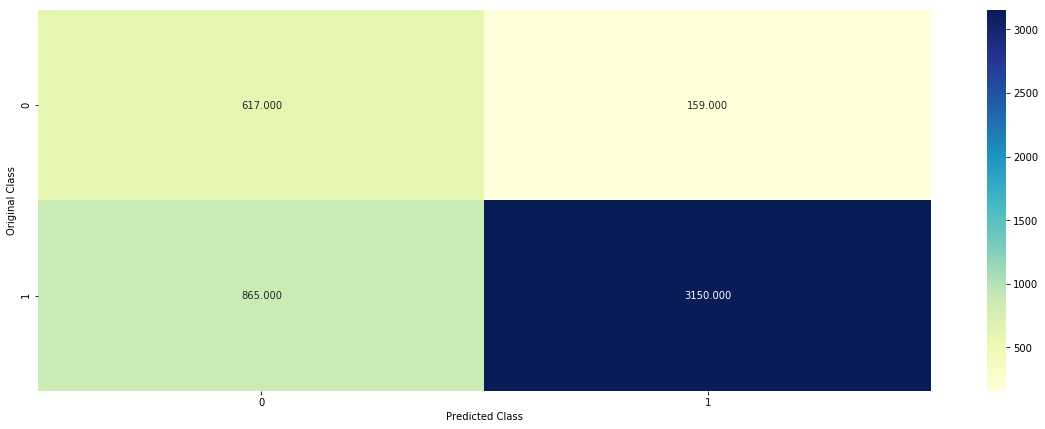

For values of best alpha =  1000 The test AUC is: 0.7898305003145423


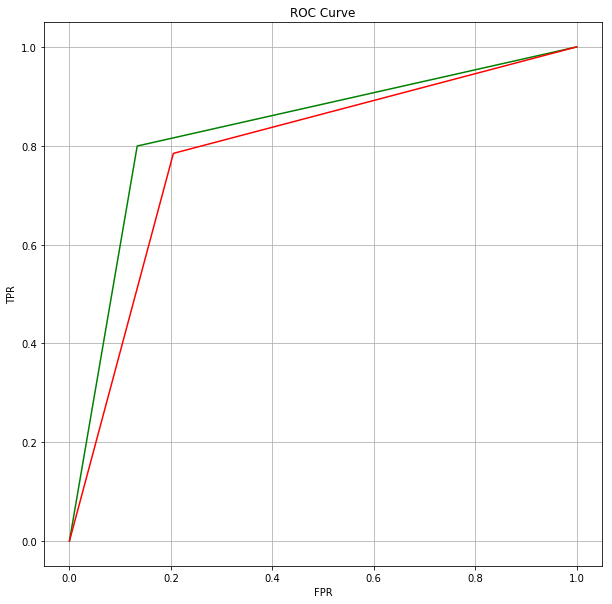

In [114]:
clf,alph = performHyperParameterTuningRBF(train,cv,test)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [109]:
train = loadPickleData("tfidf_w2v_train_rbf.pickle")
test = loadPickleData('tfidf_w2v_test_rbf.pickle')
cv = loadPickleData('tfidf_w2v_cv_rbf.pickle')

for alpha = 0.001 and gamma = 0.0001 
Area: 0.5
for alpha = 0.001 and gamma = 0.001 
Area: 0.5
for alpha = 0.001 and gamma = 0.01 
Area: 0.5
for alpha = 0.001 and gamma = 0.1 
Area: 0.6494899862231608
for alpha = 0.001 and gamma = 1 
Area: 0.7491374435239831
for alpha = 0.001 and gamma = 10 
Area: 0.7793098746046929
for alpha = 0.001 and gamma = 100 
Area: 0.7851715487212807
for alpha = 0.001 and gamma = 1000 
Area: 0.7851394629238584
for alpha = 0.01 and gamma = 0.0001 
Area: 0.5
for alpha = 0.01 and gamma = 0.001 
Area: 0.5
for alpha = 0.01 and gamma = 0.01 
Area: 0.6395268447829496
for alpha = 0.01 and gamma = 0.1 
Area: 0.748122980850795
for alpha = 0.01 and gamma = 1 
Area: 0.7767871287823641
for alpha = 0.01 and gamma = 10 
Area: 0.7834271341567351
for alpha = 0.01 and gamma = 100 
Area: 0.788118679348578
for alpha = 0.01 and gamma = 1000 
Area: 0.7906845404611933
for alpha = 0.1 and gamma = 0.0001 
Area: 0.5
for alpha = 0.1 and gamma = 0.001 
Area: 0.5
for alpha = 0.1 and gamma 

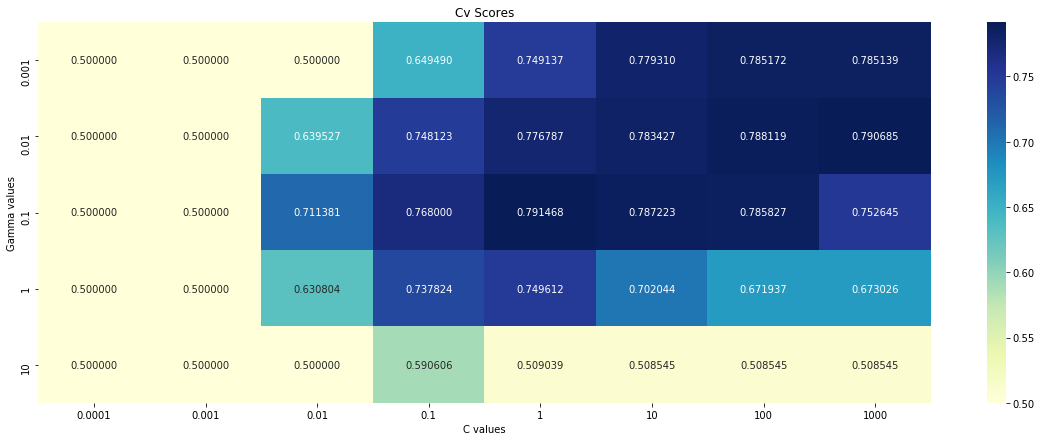

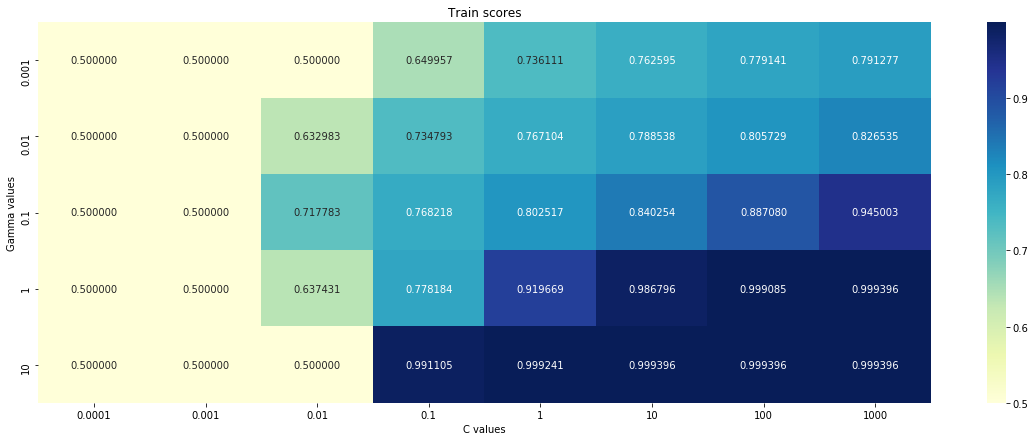

20
best alph = 1 and gamma =0.1 
-------------------- Confusion matrix --------------------


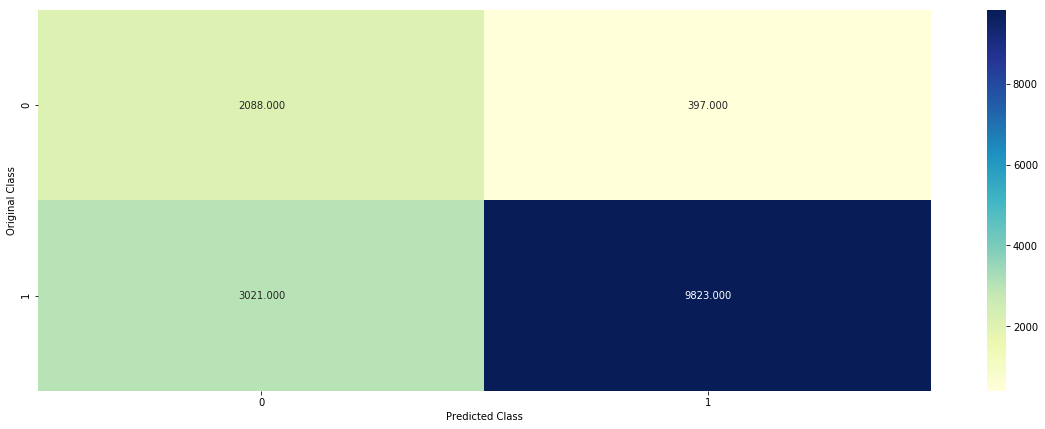

For values of best alpha =  1 The AUC is: 0.8025171740502185
For values of best alpha =  1 The cross validation AUC is: 0.7914681357951161
-------------------- Confusion matrix --------------------


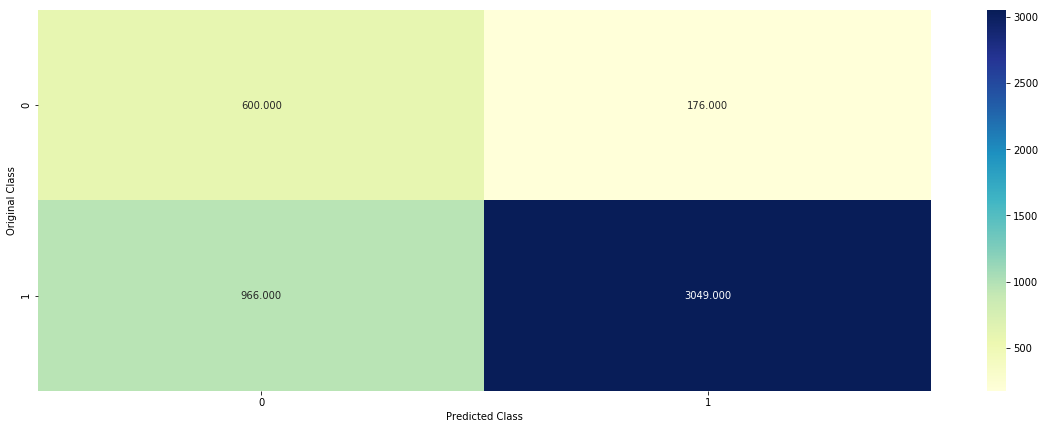

For values of best alpha =  1 The test AUC is: 0.766299058941341


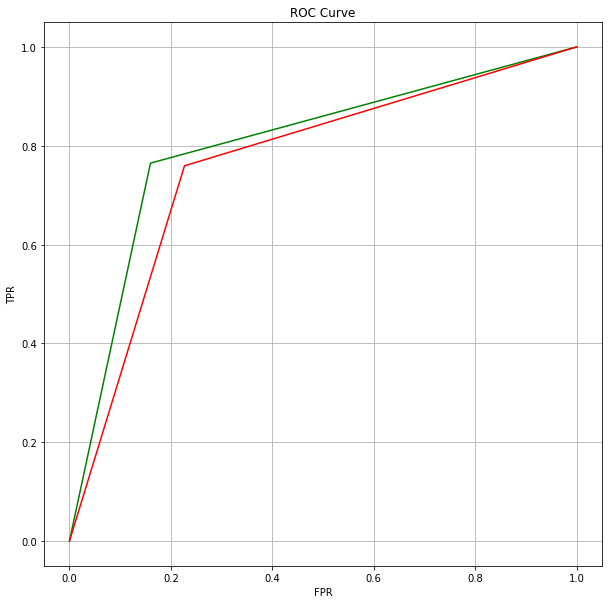

In [110]:
clf,alph = performHyperParameterTuningRBF(train,cv,test)

# [6] Conclusions

| Vectorizer | Alpha  | Regularizer | Kernel | AUC   |
|------------|--------|-------------|--------|-------|
| BOW        | 0.001  | l2          | Linear | 0.82  |
| TFIDF      | 0.0001 | l2          | Linear | 0.86  |
| AvgW2V     | 0.001  | l2          | Linear | 0.72  |
| TFIDFW2V   | 0.01   | l2          | Linear | 0.69  |

| Vectorizer  | C    | Gamma | Kernal | AUC  |
|-------------|------|-------|--------|------|
| BOW         | 10   | 0.001 | RBF    | 0.81 |
| TFIDF       | 1    | 0.1   | RBF    | 0.81 |
| AvgW2V      | 1000 | 0.01  | RBF    | 0.78 |
| TFIDFW2V    | 1    | 0.1   | RBF    | 0.76 |
